In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.nn import functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset

from tqdm.auto import tqdm

import pandas as pd

In [2]:
# Getting device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}\t" + (f"{torch.cuda.get_device_name(0)}" if torch.cuda.is_available() else "CPU"))

Using device: cuda	Tesla T4


In [3]:
# For the dataset CIFAR10, we try to use the U-NET
def sinusoidal_embedding(n, d):
    # Returns the standard positional embedding
    embedding = torch.tensor([[i / 10_000 ** (2 * j / d) for j in range(d)] for i in range(n)])
    sin_mask = torch.arange(0, n, 2)

    embedding[sin_mask] = torch.sin(embedding[sin_mask])
    embedding[1 - sin_mask] = torch.cos(embedding[sin_mask])

    return embedding

class MyBlock(nn.Module):
    def __init__(self, shape, in_c, out_c, kernel_size=3, stride=1, padding=1, activation=None, normalize=True):
        super(MyBlock, self).__init__()
        self.ln = nn.LayerNorm(shape)
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size, stride, padding)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size, stride, padding)
        self.conv3 = nn.Conv2d(out_c, out_c, kernel_size, stride, padding)
        self.activation = nn.SiLU() if activation is None else activation
        self.normalize = normalize

    def forward(self, x):
        out = self.ln(x) if self.normalize else x
        out = self.conv1(out)
        out = self.activation(out)
        out = self.conv2(out)
        out = self.activation(out)
        out = self.conv3(out)
        out = self.activation(out)
        return out

In [4]:
class MyUNet(nn.Module):
  # Here is a network with 3 down and 3 up with the tiny block
    def __init__(self, n_steps=1000, time_emb_dim=100):
        super(MyUNet, self).__init__()

        # Sinusoidal embedding
        self.time_embed = nn.Embedding(n_steps, time_emb_dim)
        self.time_embed.weight.data = sinusoidal_embedding(n_steps, time_emb_dim)
        self.time_embed.requires_grad_(False)

        # First half
        self.te1 = self._make_te(time_emb_dim, 3)
        self.b1 = nn.Sequential(
            MyBlock((3, 32, 32), 3, 20),
            MyBlock((20, 32, 32), 20, 20),
            MyBlock((20, 32, 32), 20, 20)
        )
        self.down1 = nn.Conv2d(20, 20, 4, 2, 1)

        self.te2 = self._make_te(time_emb_dim, 20)
        self.b2 = nn.Sequential(
            MyBlock((20, 16, 16), 20, 40),
            MyBlock((40, 16, 16), 40, 40),
            MyBlock((40, 16, 16), 40, 40)
        )
        self.down2 = nn.Conv2d(40, 40, 4, 2, 1)

        self.te3 = self._make_te(time_emb_dim, 40)
        self.b3 = nn.Sequential(
            MyBlock((40, 8, 8), 40, 80),
            MyBlock((80, 8, 8), 80, 80),
            MyBlock((80, 8, 8), 80, 80)
        )
        self.down3 = nn.Sequential(
            nn.Conv2d(80, 80, 4, 2, 1),
            nn.SiLU(),
            nn.Conv2d(80, 80, 4, 2, 1)
        )

        # Bottleneck
        self.te_mid = self._make_te(time_emb_dim, 80)
        self.b_mid = nn.Sequential(
            MyBlock((80, 2, 2), 80, 40),
            MyBlock((40, 2, 2), 40, 40),
            MyBlock((40, 2, 2), 40, 80)
        )

        # Second half
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(80, 80, 4, 2, 1),
            nn.SiLU(),
            nn.ConvTranspose2d(80, 80, 4, 2, 1)
        )

        self.te4 = self._make_te(time_emb_dim, 160)
        self.b4 = nn.Sequential(
            MyBlock((160, 8, 8), 160, 80),
            MyBlock((80, 8, 8), 80, 40),
            MyBlock((40, 8, 8), 40, 40)
        )

        self.up2 = nn.ConvTranspose2d(40, 40, 4, 2, 1)
        self.te5 = self._make_te(time_emb_dim, 80)
        self.b5 = nn.Sequential(
            MyBlock((80, 16, 16), 80, 40),
            MyBlock((40, 16, 16), 40, 20),
            MyBlock((20, 16, 16), 20, 20)
        )

        self.up3 = nn.ConvTranspose2d(20, 20, 4, 2, 1)
        self.te_out = self._make_te(time_emb_dim, 40)
        self.b_out = nn.Sequential(
            MyBlock((40, 32, 32), 40, 20),
            MyBlock((20, 32, 32), 20, 20),
            MyBlock((20, 32, 32), 20, 20, normalize=False)
        )

        self.conv_out = nn.Conv2d(20, 3, 3, 1, 1)

    def forward(self, x, t):
        # x is (N, 4, 32, 32) (image with positional embedding stacked on channel dimension)
        t = self.time_embed(t)
        n = len(x)
        out1 = self.b1(x + self.te1(t).reshape(n, -1, 1, 1))
        out2 = self.b2(self.down1(out1) + self.te2(t).reshape(n, -1, 1, 1))
        out3 = self.b3(self.down2(out2) + self.te3(t).reshape(n, -1, 1, 1))

        out_mid = self.b_mid(self.down3(out3) + self.te_mid(t).reshape(n, -1, 1, 1))

        out4 = torch.cat((out3, self.up1(out_mid)), dim=1)
        out4 = self.b4(out4 + self.te4(t).reshape(n, -1, 1, 1))

        out5 = torch.cat((out2, self.up2(out4)), dim=1)
        out5 = self.b5(out5 + self.te5(t).reshape(n, -1, 1, 1))

        out = torch.cat((out1, self.up3(out5)), dim=1)
        out = self.b_out(out + self.te_out(t).reshape(n, -1, 1, 1))

        out = self.conv_out(out)

        return out

    def _make_te(self, dim_in, dim_out):
        return nn.Sequential(nn.Linear(dim_in, dim_out), nn.SiLU(), nn.Linear(dim_out, dim_out))

In [7]:
class DDPM(nn.Module):
    def __init__(self, network, num_timesteps, beta_start=0.0001, beta_end=0.02, device=device) -> None:
        super(DDPM, self).__init__()
        self.num_timesteps = num_timesteps
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps, dtype=torch.float32).to(device)
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.)
        self.network = network.to(device)

    def add_noise(self, x_start, x_noise, timesteps):
        # The forward process

        sqrt_alphas_cumprod = self.alphas_cumprod ** 0.5
        sqrt_one_minus_alphas_cumprod = (1 - self.alphas_cumprod) ** 0.5

        s1 = sqrt_alphas_cumprod[timesteps].to(device)
        s2 = sqrt_one_minus_alphas_cumprod[timesteps].to(device)
        s1 = s1.reshape(-1, 1).unsqueeze(2).unsqueeze(3)
        s2 = s2.reshape(-1, 1).unsqueeze(2).unsqueeze(3)

        return s1 * x_start + s2 * x_noise

    def reverse(self, x, t):
        # The network return the estimation of the noise we added

        return self.network.forward(x, t)

    def reconstruct_x0(self, x_t, t, noise):

        s1 = torch.sqrt(1 / self.alphas_cumprod)[t].to(device)
        s2 = torch.sqrt(1 / self.alphas_cumprod - 1)[t].to(device)
        s1 = s1.reshape(-1, 1)
        s2 = s2.reshape(-1, 1)

        return torch.clamp(s1 * x_t - s2 * noise, -1, 1)

    def q_posterior(self, x_0, x_t, t):

        posterior_mean_coef1 = (self.betas * torch.sqrt(self.alphas_cumprod_prev) / (1. - self.alphas_cumprod)).to(device)
        posterior_mean_coef2= ((1. - self.alphas_cumprod_prev) * torch.sqrt(self.alphas) / (1. - self.alphas_cumprod)).to(device)
        s1 = posterior_mean_coef1[t].to(device)
        s2 = posterior_mean_coef2[t].to(device)
        s1 = s1.reshape(-1, 1)
        s2 = s2.reshape(-1, 1)
        mu = s1 * x_0 + s2 * x_t

        return mu

    def get_variance(self, t):

        if t == 0:
            return 0

        variance = (self.betas[t] * (1. - self.alphas_cumprod_prev[t]) / (1. - self.alphas_cumprod[t])).to(device)
        variance = variance.clip(1e-20)

        return variance

    def step(self, model_output, timestep, sample):

        t = timestep
        pred_original_sample = self.reconstruct_x0(sample, t, model_output).to(device)
        pred_prev_sample = self.q_posterior(pred_original_sample, sample, t).to(device)

        variance = 0
        if t > 0:
            noise = torch.randn_like(model_output).to(device)
            variance = ((self.get_variance(t) ** 0.5) * noise).to(device)

        pred_prev_sample = pred_prev_sample + variance

        return pred_prev_sample

In [8]:
def training_loop(model, dataloader, optimizer, num_epochs, num_timesteps, device=device):
    global_step = 0
    losses = []

    for epoch in range(num_epochs):
        model.train()
        progress_bar = tqdm(total=len(dataloader))
        progress_bar.set_description(f"Epoch {epoch}")
        for step, batch in enumerate(dataloader):
            batch = batch[0].to(device)
            noise = torch.randn(batch.shape).to(device)
            timesteps = torch.randint(0, num_timesteps, (batch.shape[0],)).long().to(device)
            noisy = model.add_noise(batch, noise, timesteps)
            noise_pred = model.reverse(noisy, timesteps)
            loss = F.mse_loss(noise_pred, noise)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "step": global_step}
            losses.append(loss.detach().item())
            progress_bar.set_postfix(**logs)
            global_step += 1
        progress_bar.close()

In [9]:
learning_rate = 1e-3
num_epochs = 200
num_timesteps = 1000

dataset = torchvision.datasets.CIFAR10(root='data', train=True, transform=transforms.ToTensor(), download=True)
dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=128, shuffle=True)

network = MyUNet()

model = DDPM(network, num_timesteps, beta_start=0.0001, beta_end=0.02, device=device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

Files already downloaded and verified


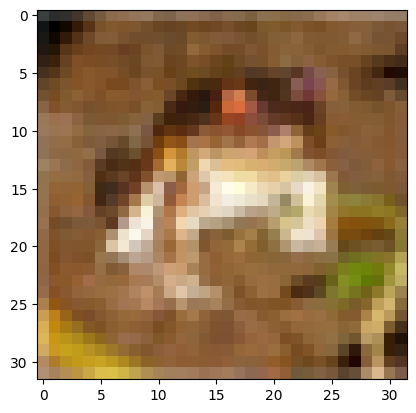

In [10]:
image = dataset.data[0]
plt.imshow(np.uint8(image))

In [11]:
training_loop(model, dataloader, optimizer, num_epochs, num_timesteps, device=device)

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [12]:
def generate_image(ddpm, channel, height, width, num_timesteps):

    with torch.no_grad():
        timesteps = list(range(ddpm.num_timesteps))[::-1]
        sample = torch.randn(1, channel, height, width).to(device)

        for i, t in enumerate(tqdm(timesteps)):
            time_tensor = (torch.ones(1, 1) * t).long().to(device)
            residual = ddpm.reverse(sample, time_tensor).to(device)
            sample = ddpm.step(residual, time_tensor[0], sample)

            if t == int(num_timesteps/2):
                image_mid = sample.squeeze().permute(1,2,0).cpu()

        image_fin = sample.squeeze().permute(1,2,0).cpu()
    return image_fin, image_mid

In [13]:
generated, generated_mid = generate_image(model, 3, 32, 32, num_timesteps)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [14]:
plt.imshow(generated)

torch.Size([32, 32, 3])

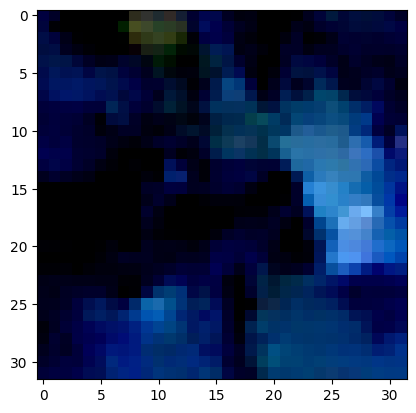

In [18]:
plt.imshow(generated_mid)

In [24]:
def show_images(sample_size, title="", is_mid=False):
    """Shows the provided images as sub-pictures in a square"""

    # Defining number of rows and columns
    fig = plt.figure(figsize=(8, 8))
    rows = int(sample_size ** (1 / 2))
    cols = round(sample_size / rows)

    # Populating figure with sub-plots
    idx = 0
    for r in range(rows):
        for c in range(cols):
            fig.add_subplot(rows, cols, idx + 1)
            generated, generated_mid = generate_image(model, 3, 32, 32, num_timesteps)
            if is_mid:
                plt.imshow(generated_mid)
            else:
                plt.imshow(generated)
            idx+=1
    fig.suptitle(title, fontsize=30)

    # Showing the figure
    plt.show()


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

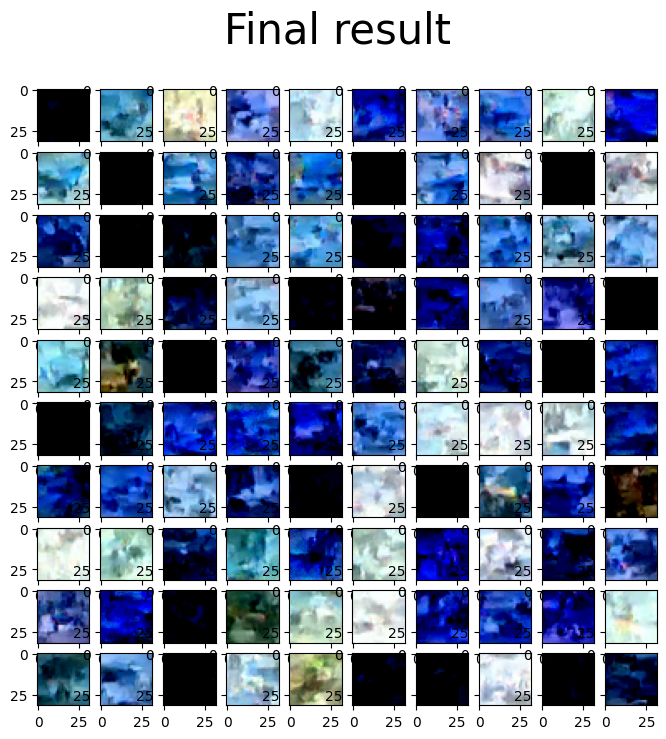

In [25]:
show_images(16, "Final result")